### Imports and Configuration

In [1]:
%load_ext autoreload
%autoreload 2

In [46]:
import numpy as np
import pandas as pd
import scipy.sparse

from collections import defaultdict, Counter

from functools import partial, reduce

import random
import math

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import normalize, StandardScaler
from sklearn.linear_model import LogisticRegression
standard_scaler = StandardScaler()
from skbayes.rvm_ard_models import ClassificationARD

import pickle

In [3]:
import sys 
import os
sys.path.append(os.path.abspath("../../ucl_irdm2017_project2_group1"))

In [4]:
import ltr.data_load
import ltr.evals

In [5]:
fpath = "../../"

### Data Load

**Please note:** Run first cell once to generate CSVs. Once generated, files can be loaded in using second cell without re-running make_rank_data_csv

In [ ]:
ltr.data_load.make_rank_data_csv(fpath, 1, 'train')
ltr.data_load.make_rank_data_csv(fpath, 1, 'vali')
ltr.data_load.make_rank_data_csv(fpath, 1, 'test')

In [6]:
data_train = pd.read_csv('{fpath}/train_fld1_df.csv'.format(fpath=fpath), index_col=0)
data_vali = pd.read_csv('{fpath}/test_fld1_df.csv'.format(fpath=fpath), index_col=0)
data_test = pd.read_csv('{fpath}/vali_fld1_df.csv'.format(fpath=fpath), index_col=0)

Combining training and validation set:

In [7]:
full_train = pd.concat([data_train, data_vali])

In [8]:
full_train.shape

(964933, 138)

### Data Preparation

Filtering data to remove queries with less than 70 documents, or greater than 200 documents. We have trained models using both unfiltered and filtered data, however the rest of this notebook uses the unfiltered versions.

In [9]:
qid_counts = dict(Counter(list(full_train['query_id'])))
filtered_qid_dict = {k: v for k, v in qid_counts.items() if v <= 200 and v >= 70}
filtered_qids = filtered_qid_dict.keys()
full_train_filtered = full_train.loc[full_train['query_id'].isin(filtered_qids)]

In [10]:
full_train_filtered.shape

(675006, 138)

Converting to numpy arrays:

In [11]:
X_train = full_train.ix[:,2:].as_matrix()
y_train = full_train.ix[:,0].as_matrix()
qid_train = full_train.ix[:,1].as_matrix()
X_test = data_test.ix[:,2:].as_matrix()
y_test = data_test.ix[:,0].as_matrix()
qid_test = data_test.ix[:,1].as_matrix()

Scaling input data to have zero mean, unit variance:

In [12]:
X_train_scaled = standard_scaler.fit_transform(X_train)
X_test_scaled = standard_scaler.transform(X_test)

### Model Training

##### Function definitions

In [13]:
def label_encoder(y):
    """
    Description:
    Generates a one-hot representation of the relevance labels
    e.g. classes: {0,1,2,3,4}. Class 2, ohe representation: [0,0,1,0,0]
    
    Inputs:
    scores - dot product between weight vector and input data matrix
    
    """
    k = len(np.unique(y))
    def ohe(a):
        x = np.zeros(k)
        x[a] = 1
        return x
    t = [ohe(yy) for yy in y]
    return np.squeeze(t)

In [14]:
def softmax_function(scores):
    """
    Description:
    Computes probability distribution over relevance label classes
    
    Inputs:
    scores - dot product between weight vector and input data matrix
    
    """
    scores = scores - np.max(scores)
    numerator = np.exp(scores).T
    denominator = np.sum(np.exp(scores),axis=1)
    class_probs = (numerator/denominator).T
    return class_probs

In [15]:
def scoring_function(w, X):
    """
    Description:
    Uses a softmax scoring function to return probabilities for each of the relevance class labels
    for each query-document pair
    
    Inputs:
    w - weight vector
    X - input data matrix (datapoints x dimensions)
    
    """
    num_examples = X.shape[0]
    scores = np.dot(X,w)
    class_probs = softmax_function(scores)
    return class_probs
    

$$
P(y=k|x) = \frac{e^{\mathbf{w}_{k}^{\top}\phi(x)}}{\sum_{d}e^{\mathbf{w}_{d}^{\top}\phi(x)}}
$$

In [16]:
def loss_function(class_probs, reg, w, X, labels):
    """
    Description:
    Computes loss and gradient of loss function for given probabilities and true class labels
    
    Inputs:
    class probs - probabilities for each relevancer class label
    reg -  regularisation parameter (lambda)
    w - weight matrix
    X - input data matrix
    labels - true relevance labels (y)
    
    """
    num_examples = X.shape[0]
    labels = label_encoder(labels)
    
    # Loss
    log_loss = np.sum(np.log(class_probs[labels.astype(bool)]))
    l2_regularisation = (reg/2)*np.sum(w**2)
    loss = (-1 / num_examples) * log_loss + l2_regularisation
    
    # Gradient
    delta_l = (-1 / num_examples) * np.dot(X.T,(labels - class_probs))
    delta_reg = reg*w
    gradient = delta_l + delta_reg
    return loss, gradient


$$
\mathcal{L}(\mathbf{W}) = \frac{1}{n}\sum_{i=1}^n[ {\mathbf{w}_{y_i}^{\top}\phi(x_i)} - log(\sum_{d}e^{\mathbf{w}_{d}^{\top}\phi(x_i)})]
$$

$$
\frac{\partial\mathcal{L}}{\partial\mathbf{w_k}} = \frac{1}{n}\sum_{i=1}^n \phi(x_i) - P(y_i=k|x_i)\phi(x_i)
$$

##### Training

Training using softmax scoring function, log loss and gradient descent to optimise weights:

In [23]:
def optimal_w_function(X,y,reg,max_iter = 1000, learning_rate = 0.1):
    w = np.zeros([X.shape[1],len(np.unique(y))])
    losses = []
    for i in range(0,max_iter):
        class_probs = scoring_function(w,X)
        loss,grad = loss_function(class_probs, reg, w, X, y)
        
        losses.append(loss)
        if (i>0):
            prevmin = np.min(losses[0:-1])
            if loss>prevmin:
                print('Divergent Transitions, reducing learning rate to ' + str(learning_rate*0.9))
                learning_rate = learning_rate*0.9
            if (np.abs(losses[-2] - loss) < 3e-4):
                print('Converged in ' + str(i+1)+ ' steps. Regularisation parameter (lambda) = ' + str(reg) +'. Loss = ' + str(loss))
                return w,loss,losses,class_probs
        w = w - (learning_rate * grad)
    
    print('Not converged. Regularisation parameter (lambda) = ' + str(reg) +'. Loss =  ' + str(loss))
    return w,loss,losses,class_probs
            

In [24]:
w_opt, loss, losses, prob_train = optimal_w_function(X_train_scaled,y_train,1)

Converged in 10 steps. Regularisation parameter (lambda) = 1. Loss = 1.53249326012


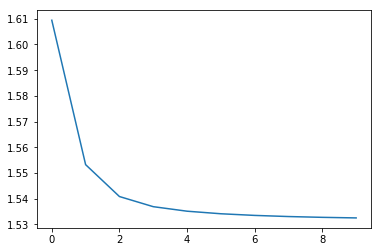

In [25]:
plt.plot(losses)
plt.show()

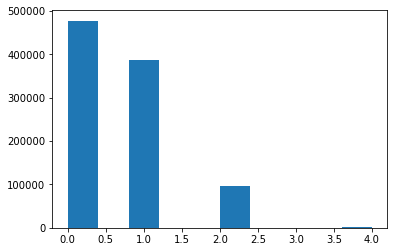

In [27]:
plt.hist(np.argmax(prob_train,axis=1))
plt.show()

### Cross-validation

Here we perform 5-fold cross-validation on the combined training and validation set to tune the regularisation parameter, lambda:

In [50]:
n = np.shape(X_train)[0]
k = 5
n_k = round(n/k)
learningRate = 0.35
maxIter = 700

allndcgs = []
allerrs = []
avgndcgs = []
avgerrs = []

for lmda in np.arange(21):
    ind = np.zeros(n, dtype = np.bool)
    ind[0:n_k] = True
    fldndcgs = []
    flderrs = []
    lam = (lmda)/10 # Min: step: max (0:0.1:2.0)
    for fld in np.arange(k):
        thisFoldXtrain = X_train_scaled[~ind,:]
        thisFoldXval = X_train_scaled[ind,:]
        thisFoldytrain = y_train[~ind]
        thisFoldyval = y_train[ind]
        thisFoldQidVal = qid_train[ind]
        
        opt_w,loss,_,_ = optimal_w_function(thisFoldXtrain,thisFoldytrain,lam,maxIter,learningRate)
        prob = softmax_function(np.dot(thisFoldXval,opt_w))
        prob_df = pd.DataFrame(data=prob, columns=['prob_0','prob_1','prob_2','prob_3','prob_4'])
        rel = prob_df.apply(lambda x: (0)*x[0] + (1)*x[1] + (2)*x[2] + (3)*x[3] + (4)*x[4],axis=1)
        query_labels = pd.DataFrame({'qid':thisFoldQidVal, 'label_true':thisFoldyval, 'ERel':rel}).groupby('qid')

        mNdcg = ltr.evals.mean_ndcg(data=query_labels, sort_cols='ERel')
        fldndcgs.append(mNdcg)
        mErr = ltr.evals.mean_err(data=query_labels, sort_cols='ERel')
        flderrs.append(mErr)
        ind = np.roll(ind,n_k)
    
    avgerrs.append(np.mean(flderrs))
    avgndcgs.append(np.mean(fldndcgs))
    allerrs.append(flderrs)
    allndcgs.append(fldndcgs)
    print('Lambda: ' + str(lam) + '  Average ERR: ' + str(avgerrs[-1]) + '  Average NDCG: ' + str(avgndcgs[-1]))    

Converged in 26 steps. Regularisation parameter (lambda) = 0.0. Loss = 1.48245331641
Converged in 26 steps. Regularisation parameter (lambda) = 0.0. Loss = 1.48571153495
Converged in 26 steps. Regularisation parameter (lambda) = 0.0. Loss = 1.48082446063
Converged in 26 steps. Regularisation parameter (lambda) = 0.0. Loss = 1.48168416304
Converged in 26 steps. Regularisation parameter (lambda) = 0.0. Loss = 1.47913524137
Lambda: 0.0  Average ERR: 0.275456540081  Average NDCG: 0.324965822374
Converged in 14 steps. Regularisation parameter (lambda) = 0.1. Loss = 1.49802241962
Converged in 14 steps. Regularisation parameter (lambda) = 0.1. Loss = 1.50108163571
Converged in 14 steps. Regularisation parameter (lambda) = 0.1. Loss = 1.4960853332
Converged in 14 steps. Regularisation parameter (lambda) = 0.1. Loss = 1.49757815552
Converged in 14 steps. Regularisation parameter (lambda) = 0.1. Loss = 1.49492227647
Lambda: 0.1  Average ERR: 0.281179231717  Average NDCG: 0.332741171356
Converged

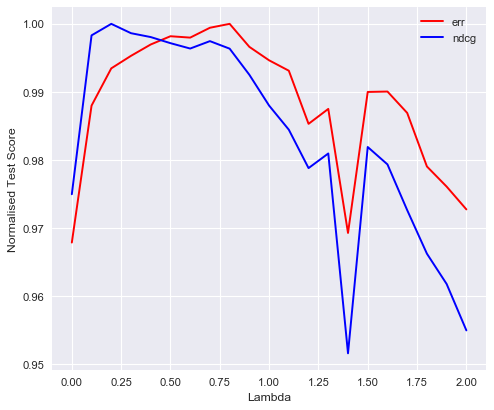

In [51]:
plt.figure(num=None, figsize=(7, 6), dpi=80, facecolor='w', edgecolor='k')
plt.plot(np.arange(21)/10, avgerrs/max(avgerrs),'r',label = 'err')
plt.plot(np.arange(21)/10, avgndcgs/max(avgndcgs),'b',label = 'ndcg')
plt.xlabel('Lambda')
plt.ylabel('Normalised Test Score')
plt.legend()
#plt.savefig('valcores.png')
plt.show()

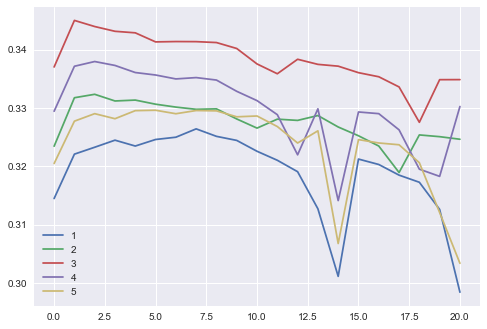

In [52]:
for j in [0,1,2,3,4]:
    plt.plot(np.array(allndcgs)[:,j],label=j+1)
    
plt.legend()
plt.show()

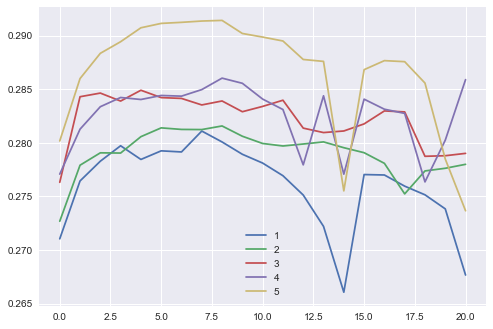

In [53]:
for j in [0,1,2,3,4]:
    plt.plot(np.array(allerrs)[:,j],label=j+1)
    
plt.legend()
plt.show()

### Model Evaluation

Creating dataframes of probabilities for each class:

In [29]:
prob_test = softmax_function(np.dot(X_test_scaled,w_opt))
train_prob_df = pd.DataFrame(data=prob_train, columns=['prob_0','prob_1','prob_2','prob_3','prob_4'])
test_prob_df = pd.DataFrame(data=prob_test, columns=['prob_0','prob_1','prob_2','prob_3','prob_4'])

In [30]:
train_prob_df.head(1)

,prob_0,prob_1,prob_2,prob_3,prob_4
0,0.231294,0.168551,0.197467,0.202586,0.200102


Calculating Expected Relevance as per Li, P., Burges, C. and Wu, Q. 2007. McRank: Learning to rank using multiple classification and gradient boosting. NIPS'07 Proceedings of the 20th International Conference on Neural Information Processing Systems. 2007: 897-904:

In [31]:
# Weights for each class
w0 = 1
w1 = 2
w2 = 3
w3 = 4
w4 = 5

train_rel = train_prob_df.apply(lambda x: w0*x[0] + w1*x[1] + w2*x[2] + w3*x[3] + w4*x[4],axis=1)
test_rel = test_prob_df.apply(lambda x: w0*x[0] + w1*x[1] + w2*x[2] + w3*x[3] + w4*x[4],axis=1)

Creating dataframes in format required for utils.rank_query (Query ID, True label, Expected relevance):

In [32]:
query_labels_train = pd.DataFrame({'qid':qid_train, 'label_true':y_train, 'ERel':train_rel}).groupby('qid')
query_labels_test = pd.DataFrame({'qid':qid_test, 'label_true':y_test, 'ERel':test_rel}).groupby('qid')

##### Accuracy

Calculating accuracy (proportion of correctly predicted labels:

$$
Accuracy = \frac{\sum_{i}^{n}\mathcal{I}(y_{pred,i} = y_{true,i})}{n}
$$

where $\mathcal{I}$ is an indicator function which equals 1 if the predicted label is equal to the true label, and 0 otherwise

In [33]:
print('Training Accuracy: ' + str(ltr.evals.accuracy(prob_train, y_train)))
print('Test Accuracy: ' + str(ltr.evals.accuracy(prob_test, y_test)))

Training Accuracy: 0.519428810083
Test Accuracy: 0.509583055271


##### Mean Normalised Discounted Cumulative Gain (NDCG)

We used the following formulation of NDCG:

$$
nDCG_{p} = \frac{DCG_{p}}{IDCG_{p}}
$$

where:

$$
DCG_{p} = \sum_{i=1}^{p} \frac{rel_{i}}{\log_2(i+1)}
$$

$$
IDCG_{p} = \sum_{i=1}^{|REL|} \frac{2^{rel_{i}}}{\log_2(i+1)}
$$

In [37]:
print('Mean Train NDCG ' + str(ltr.evals.mean_ndcg(data=query_labels_train, sort_cols='ERel', non_linear_gain='y')))
print('Mean Test NDCG ' + str(ltr.evals.mean_ndcg(data=query_labels_test,sort_cols='ERel', non_linear_gain='y')))

Mean Train NDCG 0.325798813466
Mean Test NDCG 0.330226362307


##### Mean Expected Reciprocal Rank (ERR)

We used the following formulation of ERR:  
$$
ERR := \sum_{r=1}^{n} \dfrac{1}{r} P(\textrm{user stops at position } r)
$$

$$
    := \sum_{r=1}^{n} \dfrac{1}{r}\prod_{i=1}^{r-1}(1-R_{i})R_{r}
$$

In [38]:
print('Mean Train ERR ' + str(ltr.evals.mean_err(data=query_labels_train, sort_cols='ERel')))
print('Mean Test ERR ' + str(ltr.evals.mean_err(data=query_labels_test, sort_cols='ERel')))

Mean Train ERR 0.28044092066
Mean Test ERR 0.284659597177


### Regularisation

#### Bayesian Logsitic Regression with regularisation parameter lambda tuned via marginal likelihood maximisation

Training:  
ARD: Automatic Relevance Determination (i.e. variable selection)

In [ ]:
# rvm = ClassificationARD()          
# f = rvm.fit(X_train,y_train)       

Saved model can be opened as a pickle file:

In [39]:
with open('../models/ardFit.pkl', 'rb') as fid:
    f = pickle.load(fid) 

Evaluation:

In [40]:
p = f.predict_proba(X_test)
accuracy = f.score(X_test,y_test)
prob_df = pd.DataFrame(data=p, columns=['prob_0','prob_1','prob_2','prob_3','prob_4'])
rel = prob_df.apply(lambda x: 0*x[0] + 1*x[1] + 2*x[2] + 3*x[3] + 4*x[4],axis=1)
query_labels = pd.DataFrame({'qid':qid_test, 'label_true':y_test, 'ERel':rel}).groupby('qid')
mNdcg = ltr.evals.mean_ndcg(data=query_labels, sort_cols='ERel')
mErr = ltr.evals.mean_err(data=query_labels, sort_cols='ERel')
print('Classification Accuracy: ' + str(accuracy) + ' Mean ERR: ' + str(mErr) + ' Mean NDCG: ' + str(mNdcg))

Classification Accuracy: 0.548391347409 Mean ERR: 0.338555034261 Mean NDCG: 0.382874246935


#### Logistic Regression using L1 regularisation (LASSO)

Training:

In [ ]:
# lr = LogisticRegression(penalty = 'l1')               
# lr.fit(X_train[0:100000], y_train[0:100000])  

Saved model can be opened as a pickle file:

In [41]:
with open('../models/L1_logistic.pkl', 'rb') as fid:
    lr = pickle.load(fid)

Evaluation:

In [44]:
p = lr.predict_proba(X_test)
accuracy = lr.score(X_test,y_test)
prob_df = pd.DataFrame(data=p, columns=['prob_0','prob_1','prob_2','prob_3','prob_4'])
rel = prob_df.apply(lambda x: 0*x[0] + 1*x[1] + 2*x[2] + 3*x[3] + 4*x[4],axis=1)
query_labels = pd.DataFrame({'qid':qid_test, 'label_true':y_test, 'ERel':rel}).groupby('qid')
mNdcg = ltr.evals.mean_ndcg(data=query_labels, sort_cols='ERel')
mErr = ltr.evals.mean_err(data=query_labels, sort_cols='ERel')
print('Classification Accuracy: ' + str(accuracy) + ' Mean ERR: ' + str(mErr) + ' Mean NDCG: ' + str(mNdcg))

/Users/gpeake/anaconda/lib/python3.6/site-packages/sklearn/linear_model/base.py:352: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)


Classification Accuracy: 0.548365843602 Mean ERR: 0.346016735165 Mean NDCG: 0.388448513538


#### Logistic Regression using L2 regularisation (Ridge) - using optimised regularisation parameter (lambda) by 5-fold CV

Training:

In [56]:
w_opt_cv, loss_cv, losses_cv, prob_train_cv = optimal_w_function(X_train_scaled,y_train,0.4)

Converged in 15 steps. Regularisation parameter (lambda) = 0.4. Loss = 1.5169892323


Evaluation:

In [61]:
p = scoring_function(w_opt_cv, X_test_scaled)
prob_df = pd.DataFrame(data=p, columns=['prob_0','prob_1','prob_2','prob_3','prob_4'])
rel = prob_df.apply(lambda x: 0*x[0] + 1*x[1] + 2*x[2] + 3*x[3] + 4*x[4],axis=1)
query_labels = pd.DataFrame({'qid':qid_test, 'label_true':y_test, 'ERel':rel}).groupby('qid')
mNdcg = ltr.evals.mean_ndcg(data=query_labels, sort_cols='ERel')
mErr = ltr.evals.mean_err(data=query_labels, sort_cols='ERel')
print('Classification Accuracy: ' + str(accuracy) + ' Mean ERR: ' + str(mErr) + ' Mean NDCG: ' + str(mNdcg))

Classification Accuracy: 0.548365843602 Mean ERR: 0.286831236154 Mean NDCG: 0.33237518722


##### Heatmap of weights for Bayesian and Logistic Regression (L1 regularisation):

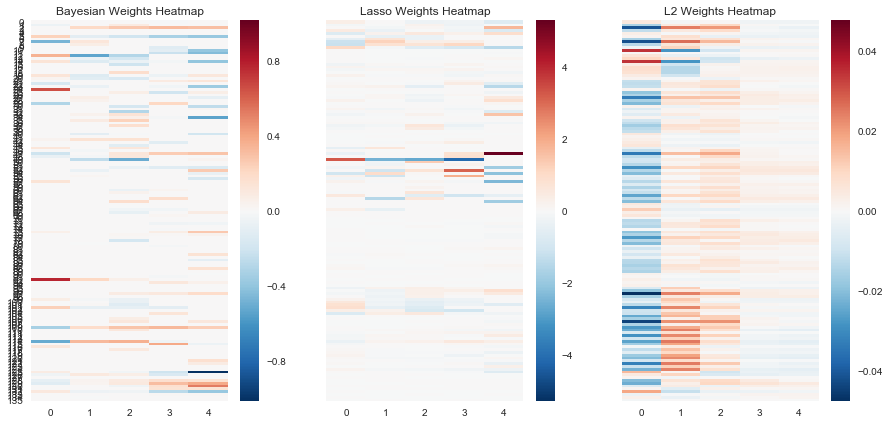

In [62]:
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, sharey=True, figsize = (15,7))
sns.heatmap(f.coef_.T, ax=ax1)
sns.heatmap(lr.coef_.T, ax=ax2)
sns.heatmap(w_opt_cv, ax=ax3)
ax1.set_title('Bayesian Weights Heatmap')
ax2.set_title('Lasso Weights Heatmap')
ax3.set_title('L2 Weights Heatmap')
sns.plt.show()